# Problem Statement

    A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia. The data is provided in the CSV file below.



    The company is looking at prospective properties to buy to enter the market. You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.



    The company wants to know:

    Which variables are significant in predicting the price of a house, and

    How well those variables describe the price of a house.

## Loading important libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
house = pd.read_csv('train.csv')

In [3]:
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [5]:
# listing all missing values percentage wise
(house.isnull().sum() * 100 / len(house)).sort_values(ascending=False).head()

PoolQC         99.520548
MiscFeature    96.301370
Alley          93.767123
Fence          80.753425
FireplaceQu    47.260274
dtype: float64

In [6]:
# Counting unique value in each categorical column
cat_col =house.select_dtypes(include=['object'])

for i in list(cat_col.columns):
    print("We have {} unique value in {} column: {}.".format(len(cat_col[i].unique()), 
                                                     i, cat_col[i].unique()))
    print('*'*140)

We have 5 unique value in MSZoning column: ['RL' 'RM' 'C (all)' 'FV' 'RH'].
********************************************************************************************************************************************
We have 2 unique value in Street column: ['Pave' 'Grvl'].
********************************************************************************************************************************************
We have 3 unique value in Alley column: [nan 'Grvl' 'Pave'].
********************************************************************************************************************************************
We have 4 unique value in LotShape column: ['Reg' 'IR1' 'IR2' 'IR3'].
********************************************************************************************************************************************
We have 4 unique value in LandContour column: ['Lvl' 'Bnk' 'Low' 'HLS'].
**************************************************************************************************

## analysing the target feature , i.e SalePrice

In [7]:
house['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

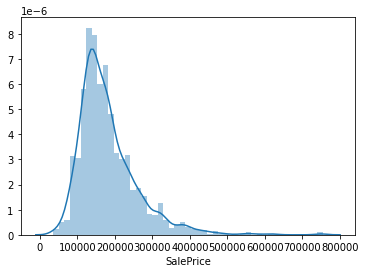

In [8]:
#histogram
sns.distplot(house['SalePrice']);


In [9]:
#skewness and kurtosis
print("Skewness: %f" % house['SalePrice'].skew())
print("Kurtosis: %f" % house['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


## Relationship with numerical variables

#### some important numerical feature which can affect the house price significantly based on business requirements
    GrLivArea,PoolArea,GarageArea,OpenPorchSF,LotArea,TotalBsmtSF,MasVnrArea

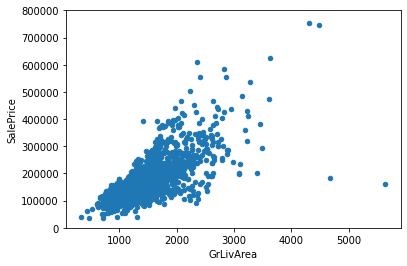

In [10]:
#scatter plot grlivarea/saleprice
var = 'GrLivArea'
data = pd.concat([house['SalePrice'], house[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));


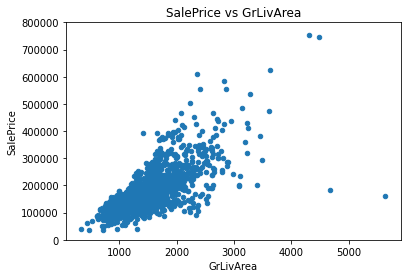

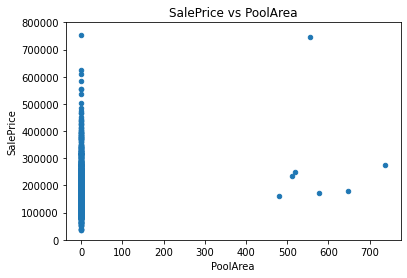

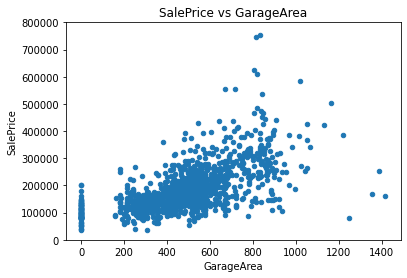

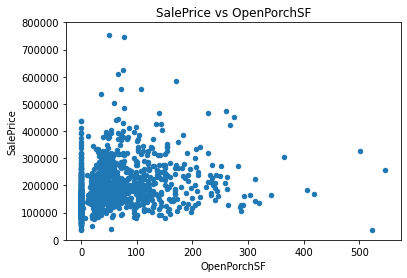

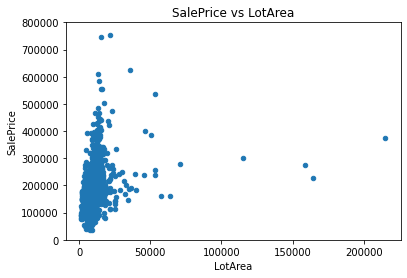

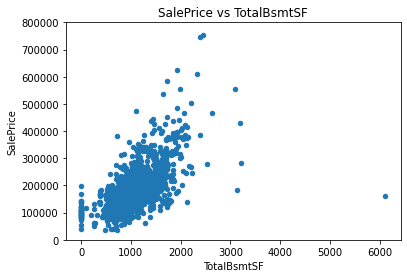

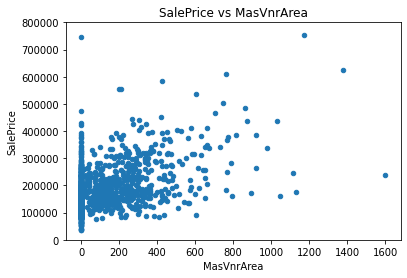

In [11]:
# Scatter plot between target feature(SalePrice) and the important features
for col in ('GrLivArea','PoolArea','GarageArea','OpenPorchSF','LotArea','TotalBsmtSF','MasVnrArea'):
    data = pd.concat([house['SalePrice'], house[col]], axis=1)
    data.plot.scatter(x=col, y='SalePrice', ylim=(0,800000),title = "SalePrice vs {}".format(col));


## Data Cleaning and feature engineering

In [12]:
#check missing ratios
total_data_na = ((house.isnull().sum() / len(house)) * 100).sort_values(ascending=False)

In [13]:
#check missing ratios top 30
total_data_na = total_data_na.drop(total_data_na[total_data_na == 0].index).sort_values(ascending=False)[:30]
total_data_na


PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageYrBlt      5.547945
GarageCond       5.547945
GarageType       5.547945
GarageFinish     5.547945
GarageQual       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
BsmtQual         2.534247
MasVnrType       0.547945
MasVnrArea       0.547945
Electrical       0.068493
dtype: float64

Text(0.5, 1.0, 'Percent missing data by feature')

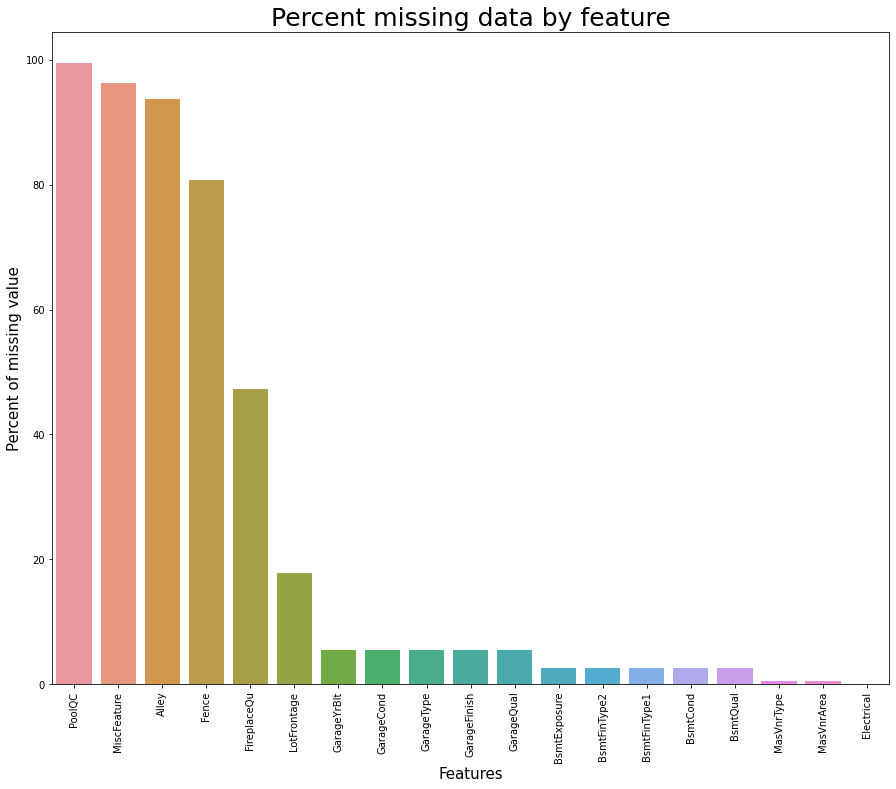

In [14]:
# plotting missing values
plt.subplots(figsize=(15,12))
plt.xticks(rotation='90')
sns.barplot(x=total_data_na.index, y=total_data_na)

plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing value', fontsize=15)
plt.title('Percent missing data by feature', fontsize=25)

In [15]:
# dropping columns having Nan values more than 75%
house = house.loc[:, house.isnull().mean() < .75]


In [16]:
# FireplaceQu - NA means no fireplace, so replacing with None
house["FireplaceQu"] = house["FireplaceQu"].fillna("None")

## Imputation according to the required DataType and Data_description text file

In [17]:
# for LotFrontage, replacing missing value with median
house["LotFrontage"]=house.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

# replacing Na values to None because Na means there is no facility for Garage
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    house[col] =house[col].fillna('None')
    
# Replacing missing with 0 (No garage = no cars in such garage)
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    house[col] = house[col].fillna(0)

# Missing value in these feature means no basement (replace with 0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    house[col] = house[col].fillna(0)
    
# NaN means in these column is no basement
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    house[col] = house[col].fillna('None')
    
# NA means no masonry veneer for houses (Fill zero for area and None for type)
house["MasVnrType"] = house["MasVnrType"].fillna("None")
house["MasVnrArea"] = house["MasVnrArea"].fillna(0)


# Filling MSZoning with most common value 'RL'
house['MSZoning'] = house['MSZoning'].fillna(house['MSZoning'].mode()[0])


# For Utilitites, most of the records are 'AllPub'. It won't help in prediction
house = house.drop(['Utilities'], axis=1)


# data description says- Assume typical(Typ) unless deductions are warranted
house["Functional"] = house["Functional"].fillna("Typ")


# replacing with most repeated "SBrkr" value
house['Electrical'] = house['Electrical'].fillna(house['Electrical'].mode()[0])

# set "TA" most frequent in place of missing value
house['KitchenQual'] = house['KitchenQual'].fillna(house['KitchenQual'].mode()[0])


# replacing with most common value 
house['Exterior1st'] = house['Exterior1st'].fillna(house['Exterior1st'].mode()[0])
house['Exterior2nd'] = house['Exterior2nd'].fillna(house['Exterior2nd'].mode()[0])


# replacing with most common value again
house['SaleType'] = house['SaleType'].fillna(house['SaleType'].mode()[0])

# MSSubClass-type of dwelling, NA means no building class. (fill with None)
house['MSSubClass'] = house['MSSubClass'].fillna("None")


## Now checking the missing values


In [18]:
((house.isnull().sum()/len(house))*100).sort_values(ascending=False).head()

SalePrice      0.0
Foundation     0.0
RoofMatl       0.0
Exterior1st    0.0
Exterior2nd    0.0
dtype: float64

### converting data types of some columns whcih are int but it should be str

In [19]:
#MSSubClass=The building class
house['MSSubClass'] = house['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
house['OverallCond'] = house['OverallCond'].astype(str)


### Visualizing the cleaned dataset

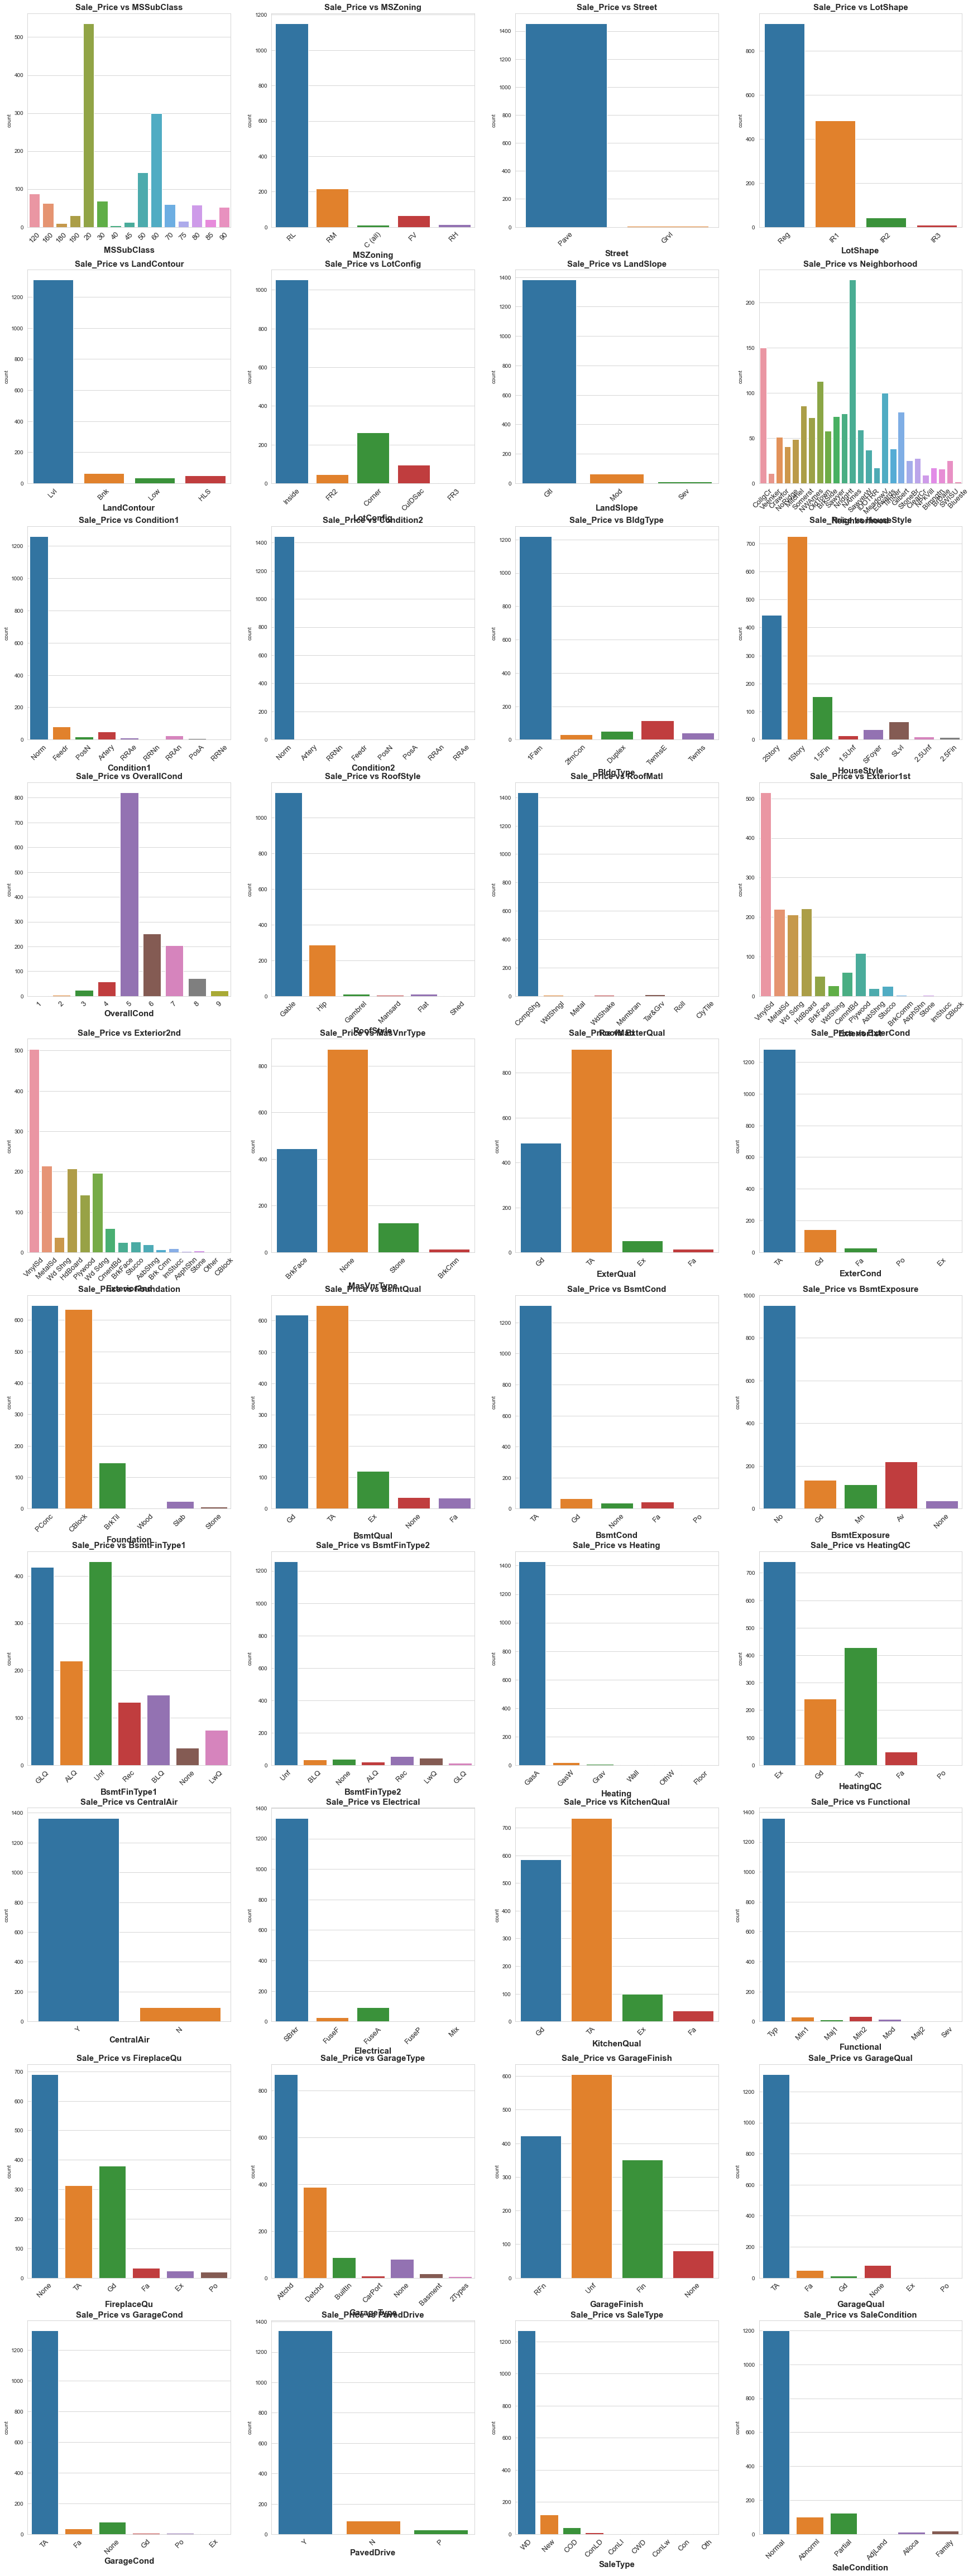

In [20]:
df_cat = house.select_dtypes(include = 'object')
#analysis of categorical variables 
plt.figure(figsize=(30,100))
for i in enumerate(df_cat.columns.values):
    sns.set_style("whitegrid")
    plt.subplot(12,4,i[0]+1)
    sns.countplot(i[1],data = df_cat)
    plt.xticks(rotation = 45,fontsize=13)
    plt.xlabel(i[1],fontsize = 15,fontweight = 'bold')
    plt.title('Sale_Price'+' vs '+i[1],fontweight = 'bold',fontsize=15)

In [21]:
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [22]:
num_vars = house.select_dtypes(exclude=['object']).columns.tolist()

In [23]:
cat_cols = house.select_dtypes(include=['object']).columns.tolist()

## using dummies to convert categorical columns to numerical columns

In [24]:
# get dummy variables for season, weekday, mnth and weathersit
dummy_vars = pd.get_dummies(house[cat_cols],drop_first=True)

# concat the dummy df with original df
house = pd.concat([house,dummy_vars], axis = 1)

# drop season column
house.drop(cat_cols, axis=1, inplace=True)

In [25]:
house.shape

(1460, 267)

## Splitting data into train and test 

In [26]:
from sklearn.model_selection import train_test_split
# We specify this so that the train and test data set always have the same rows, respectively
# Split train test dataset
df_train, df_test = train_test_split(house, train_size = 0.7, random_state = 10 )
print(df_train.shape)
print(df_test.shape)


(1021, 267)
(439, 267)


### Rescaling the Features
We will use MinMax scaling.

During EDA we could observe that there is different range of data in the data set. So it becomes important to scale the data. Here we will be using Min-Max scaling (normalisation) to scale both training and tesing dataset.

In [27]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [28]:
# Scaling of train set
# instantiate an object
scaler = MinMaxScaler()
# fit and transform on training data
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_train.head()

,Id,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
373,0.255830,0.198630,0.043628,0.285714,0.586957,0.050000,0.0000,0.075833,0.122117,0.000000,...,0,0,0,0,1,0,0,0,1,0
20,0.013717,0.273973,0.060366,0.714286,0.963768,0.933333,0.2375,0.000000,0.000000,0.495719,...,0,0,1,0,0,0,0,0,0,1
800,0.548697,0.198630,0.053743,0.428571,0.905797,0.783333,0.0000,0.081857,0.000000,0.065925,...,0,0,0,0,1,0,0,0,1,0
152,0.104252,0.202055,0.063114,0.428571,0.717391,0.350000,0.1575,0.073707,0.000000,0.175086,...,0,0,0,0,1,0,0,0,1,0
906,0.621399,0.325342,0.057029,0.714286,0.971014,0.933333,0.1300,0.011162,0.000000,0.667808,...,0,0,0,0,1,0,0,0,1,0


In [29]:
# transform test dataset 
df_test[num_vars] = scaler.transform(df_test[num_vars])
df_test.head()

,Id,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
854,0.585734,0.277397,0.077684,0.285714,0.601449,0.400000,0.000000,0.054217,0.736092,0.159247,...,0,0,0,0,1,0,0,0,0,0
381,0.261317,0.133562,0.027577,0.571429,0.971014,0.933333,0.000000,0.000000,0.000000,0.553510,...,0,0,1,0,0,0,0,0,0,1
816,0.559671,0.178082,0.047325,0.285714,0.594203,0.066667,0.000000,0.086109,0.000000,0.223459,...,0,0,0,0,1,0,0,0,1,0
577,0.395748,0.256849,0.048971,0.285714,0.681159,0.266667,0.060625,0.058115,0.373813,0.122003,...,0,0,0,0,1,0,0,0,0,0
35,0.024005,0.297945,0.056641,0.714286,0.956522,0.916667,0.082500,0.000000,0.000000,0.478168,...,0,0,0,0,1,0,0,0,1,0


<AxesSubplot:xlabel='SalePrice'>

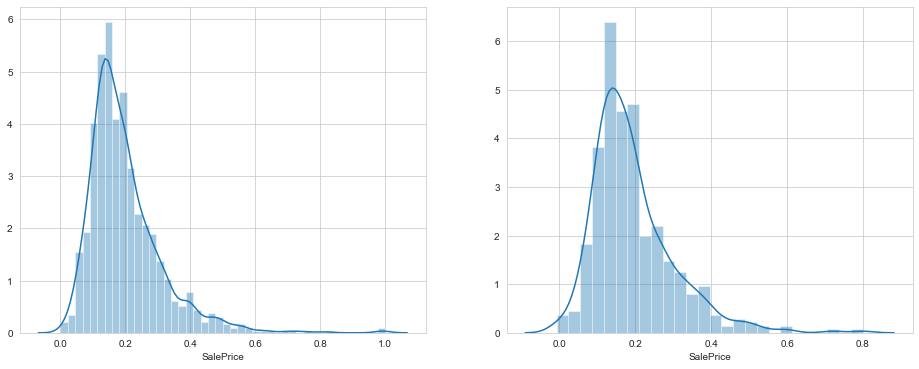

In [30]:
# distribution after scaling
plt.figure(figsize=(16,6))
plt.subplot(121)
sns.distplot(df_train.SalePrice)
plt.subplot(122)
sns.distplot(df_test.SalePrice)

In [31]:
# Creating X and y data dataframe for train set
y_train = df_train.pop('SalePrice')
X_train = df_train
X_train.head()

,Id,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
373,0.255830,0.198630,0.043628,0.285714,0.586957,0.050000,0.0000,0.075833,0.122117,0.000000,...,0,0,0,0,1,0,0,0,1,0
20,0.013717,0.273973,0.060366,0.714286,0.963768,0.933333,0.2375,0.000000,0.000000,0.495719,...,0,0,1,0,0,0,0,0,0,1
800,0.548697,0.198630,0.053743,0.428571,0.905797,0.783333,0.0000,0.081857,0.000000,0.065925,...,0,0,0,0,1,0,0,0,1,0
152,0.104252,0.202055,0.063114,0.428571,0.717391,0.350000,0.1575,0.073707,0.000000,0.175086,...,0,0,0,0,1,0,0,0,1,0
906,0.621399,0.325342,0.057029,0.714286,0.971014,0.933333,0.1300,0.011162,0.000000,0.667808,...,0,0,0,0,1,0,0,0,1,0


In [32]:
# Creating X and y data dataframe for test set
y_test = df_test.pop('SalePrice')
X_test = df_test

X_test.head()


,Id,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
854,0.585734,0.277397,0.077684,0.285714,0.601449,0.400000,0.000000,0.054217,0.736092,0.159247,...,0,0,0,0,1,0,0,0,0,0
381,0.261317,0.133562,0.027577,0.571429,0.971014,0.933333,0.000000,0.000000,0.000000,0.553510,...,0,0,1,0,0,0,0,0,0,1
816,0.559671,0.178082,0.047325,0.285714,0.594203,0.066667,0.000000,0.086109,0.000000,0.223459,...,0,0,0,0,1,0,0,0,1,0
577,0.395748,0.256849,0.048971,0.285714,0.681159,0.266667,0.060625,0.058115,0.373813,0.122003,...,0,0,0,0,1,0,0,0,0,0
35,0.024005,0.297945,0.056641,0.714286,0.956522,0.916667,0.082500,0.000000,0.000000,0.478168,...,0,0,0,0,1,0,0,0,1,0


In [33]:
# Define dictionary to store our rankings
ranks = {}
# Create our function which stores the feature rankings to the ranks dictionary
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,5), ranks)
    return dict(zip(names, ranks))

In [34]:
imp_col = X_train.columns.values

## Ridge and Lasso Regression

Let's now try predicting house prices, a dataset used in simple linear regression, to perform ridge and lasso regression.

# Ridge Regression

In [35]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    2.5s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [36]:
cv_result_r = pd.DataFrame(model_cv.cv_results_)
cv_result_r['param_alpha'] = cv_result_r['param_alpha'].astype('float32')
cv_result_r.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.014172,0.002438,0.001878,0.000286,0.0001,{'alpha': 0.0001},-0.029877,-0.028267,-0.028380,-0.030551,...,-0.029489,0.000977,13,-0.016808,-0.017353,-0.018249,-0.016381,-0.017133,-0.017185,0.000625
1,0.011871,0.000941,0.001993,0.000315,0.0010,{'alpha': 0.001},-0.029839,-0.028240,-0.028389,-0.030518,...,-0.029469,0.000969,12,-0.016824,-0.017366,-0.018244,-0.016381,-0.017120,-0.017187,0.000622
2,0.012489,0.001908,0.002441,0.000620,0.0100,{'alpha': 0.01},-0.029803,-0.028229,-0.028401,-0.030518,...,-0.029457,0.000962,11,-0.016993,-0.017571,-0.018223,-0.016427,-0.017133,-0.017269,0.000601
3,0.013375,0.002792,0.001908,0.000324,0.0500,{'alpha': 0.05},-0.030767,-0.028451,-0.028260,-0.031224,...,-0.029922,0.001288,16,-0.017896,-0.018618,-0.018318,-0.016956,-0.017794,-0.017916,0.000564
4,0.013472,0.002139,0.002068,0.000304,0.1000,{'alpha': 0.1},-0.031585,-0.028681,-0.028204,-0.031626,...,-0.030338,0.001554,21,-0.018677,-0.019495,-0.018429,-0.017524,-0.018506,-0.018526,0.000628


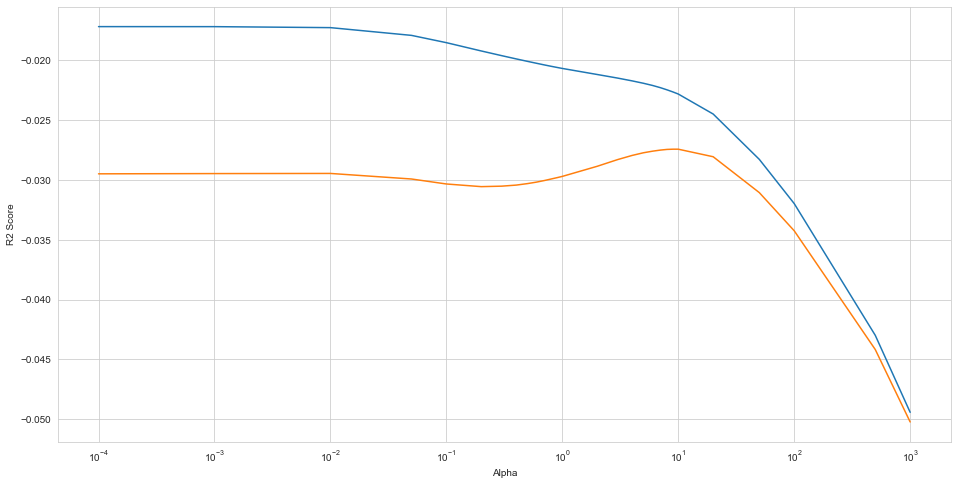

In [37]:
plt.figure(figsize=(16,8))
plt.plot(cv_result_r['param_alpha'],cv_result_r['mean_train_score'])
plt.plot(cv_result_r['param_alpha'],cv_result_r['mean_test_score'])
plt.xlabel('Alpha')
plt.xscale('log')
plt.ylabel('R2 Score')
plt.show()

In [38]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 10.0}


In [39]:
#Fitting Ridge model for alpha = 10 and printing coefficients which have been penalised
alpha = 10
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
# print(ridge.coef_)

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [40]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

0.8810602978064327
0.8849010106360434
1.5421729686051733
0.5795446808785507
0.001510453446234254
0.0013201473368531908


## Top 20 features from ridge 

In [41]:
rank_ridge = ranking(np.abs(ridge.coef_), imp_col)
sorted(rank_ridge.items(), key=lambda item: item[1] , reverse=True)[:20]

[('OverallQual', 1.0),
 ('Neighborhood_NoRidge', 0.87447),
 ('2ndFlrSF', 0.79586),
 ('GrLivArea', 0.76288),
 ('RoofMatl_WdShngl', 0.66118),
 ('TotRmsAbvGrd', 0.61091),
 ('FullBath', 0.6072),
 ('GarageCars', 0.5948),
 ('Neighborhood_StoneBr', 0.52509),
 ('1stFlrSF', 0.5021),
 ('KitchenQual_Gd', 0.47698),
 ('KitchenQual_TA', 0.43842),
 ('BsmtQual_Gd', 0.43446),
 ('Neighborhood_NridgHt', 0.43258),
 ('BsmtQual_TA', 0.42969),
 ('MasVnrArea', 0.37883),
 ('GarageArea', 0.37071),
 ('Condition2_PosN', 0.36394),
 ('ExterQual_TA', 0.36099),
 ('WoodDeckSF', 0.35907)]

## According to Problem Statement - Part II What if we choose double value of alpha

In [42]:
#Fitting Ridge model for alpha = 20 and printing coefficients which have been penalised
alpha2x = 20
ridge = Ridge(alpha=alpha2x)

ridge.fit(X_train, y_train)
# print(ridge.coef_)

Ridge(alpha=20, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [43]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

0.8637750274877595
0.8770088291969068
1.766293898360897
0.6192832728406132
0.001729964640901956
0.001410668047472923


### Top 20 features from ridge after 2x alpha

In [44]:
rank_ridge = ranking(np.abs(ridge.coef_), imp_col)
sorted(rank_ridge.items(), key=lambda item: item[1] , reverse=True)[:20]

[('OverallQual', 1.0),
 ('Neighborhood_NoRidge', 0.83116),
 ('2ndFlrSF', 0.7159),
 ('GrLivArea', 0.71263),
 ('TotRmsAbvGrd', 0.62952),
 ('FullBath', 0.62392),
 ('GarageCars', 0.59571),
 ('RoofMatl_WdShngl', 0.52),
 ('KitchenQual_Gd', 0.50169),
 ('1stFlrSF', 0.48044),
 ('KitchenQual_TA', 0.48029),
 ('Neighborhood_StoneBr', 0.46188),
 ('BsmtQual_Gd', 0.4616),
 ('Neighborhood_NridgHt', 0.45136),
 ('BsmtQual_TA', 0.44411),
 ('GarageArea', 0.44404),
 ('ExterQual_TA', 0.43881),
 ('MasVnrArea', 0.39002),
 ('BsmtExposure_Gd', 0.38413),
 ('WoodDeckSF', 0.36053)]

# Lasso

In [45]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    2.4s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [46]:
cv_result_l = pd.DataFrame(model_cv.cv_results_)
cv_result_l['param_alpha'] = cv_result_l['param_alpha'].astype('float32')
cv_result_l.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.042831,0.007122,0.002287,0.000938,0.0001,{'alpha': 0.0001},-0.029786,-0.026547,-0.026612,-0.027597,...,-0.027564,0.001182,1,-0.021798,-0.022223,-0.019853,-0.020840,-0.022045,-0.021352,0.000888
1,0.015722,0.004179,0.002070,0.000658,0.0010,{'alpha': 0.001},-0.032796,-0.030649,-0.030473,-0.029927,...,-0.030214,0.001790,2,-0.028671,-0.028681,-0.026803,-0.027929,-0.028531,-0.028123,0.000715
2,0.012173,0.002188,0.001954,0.000495,0.0100,{'alpha': 0.01},-0.066436,-0.051146,-0.053595,-0.051986,...,-0.054567,0.006086,3,-0.052937,-0.053278,-0.053717,-0.054625,-0.054060,-0.053723,0.000590
3,0.008541,0.001271,0.001882,0.000264,0.0500,{'alpha': 0.05},-0.089940,-0.078977,-0.081776,-0.084013,...,-0.081005,0.006463,4,-0.078060,-0.081619,-0.081004,-0.079879,-0.084100,-0.080932,0.001993
4,0.010753,0.001172,0.001942,0.000375,0.1000,{'alpha': 0.1},-0.089940,-0.078977,-0.081776,-0.084013,...,-0.081005,0.006463,4,-0.078060,-0.081619,-0.081004,-0.079879,-0.084100,-0.080932,0.001993


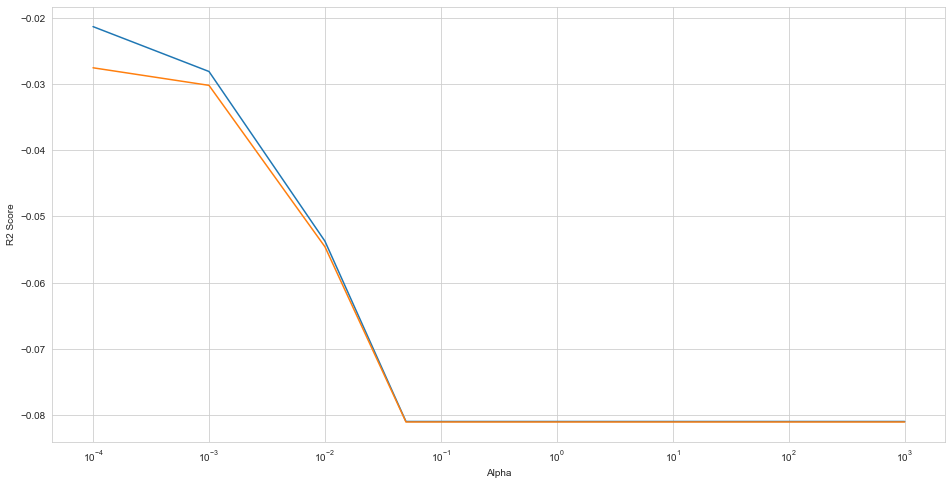

In [47]:
plt.figure(figsize=(16,8))
plt.plot(cv_result_l['param_alpha'],cv_result_l['mean_train_score'])
plt.plot(cv_result_l['param_alpha'],cv_result_l['mean_test_score'])
plt.xlabel('Alpha')
plt.xscale('log')
plt.ylabel('R2 Score')
plt.show()

In [48]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.0001}


In [49]:
#Fitting Lasso model for alpha = 0.0001 and printing coefficients which have been penalised

alpha =0.0001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [50]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.8974315441390288
0.8863776801140547
1.329903279923611
0.5721093771793059
0.0013025497354785612
0.001303210426376551


## Top 20 important features from lasso

In [51]:
rank_lasso = ranking(np.abs(lasso.coef_), imp_col)
top_lasso_features = sorted(rank_lasso.items(), key=lambda item: item[1] , reverse=True)[:20]
top_lasso_features

[('GrLivArea', 1.0),
 ('Condition2_PosN', 0.63186),
 ('RoofMatl_WdShngl', 0.46867),
 ('OverallQual', 0.41788),
 ('Neighborhood_NoRidge', 0.29778),
 ('LotArea', 0.26627),
 ('GarageCars', 0.24804),
 ('2ndFlrSF', 0.24177),
 ('Neighborhood_StoneBr', 0.23328),
 ('Neighborhood_NridgHt', 0.18645),
 ('Exterior2nd_ImStucc', 0.16239),
 ('KitchenQual_Gd', 0.15364),
 ('KitchenQual_TA', 0.13706),
 ('FullBath', 0.11942),
 ('KitchenQual_Fa', 0.11888),
 ('BsmtQual_TA', 0.11743),
 ('BsmtQual_Gd', 0.11655),
 ('Neighborhood_Crawfor', 0.111),
 ('LotShape_IR3', 0.10785),
 ('WoodDeckSF', 0.10483)]

## According to Problem Statement - Part II What if we choose double value of alpha

In [52]:
#Fitting lasso model for alpha = 0.0002 and printing coefficients which have been penalised

alpha2x =0.0002

lasso = Lasso(alpha=alpha2x)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.0002, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [53]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.8851051728013832
0.8828159942257183
1.489727092555746
0.5900431237999509
0.0014590862806618471
0.0013440617854213006


## Top 20 important features from lasso after 2x alpha

In [54]:
rank_lasso = ranking(np.abs(lasso.coef_), imp_col)
sorted(rank_lasso.items(), key=lambda item: item[1] , reverse=True)[:20]

[('GrLivArea', 1.0),
 ('OverallQual', 0.51243),
 ('Condition2_PosN', 0.39359),
 ('RoofMatl_WdShngl', 0.37889),
 ('Neighborhood_NoRidge', 0.33884),
 ('GarageCars', 0.265),
 ('Neighborhood_StoneBr', 0.24662),
 ('2ndFlrSF', 0.20915),
 ('Neighborhood_NridgHt', 0.20127),
 ('KitchenQual_Gd', 0.16485),
 ('KitchenQual_TA', 0.14966),
 ('FullBath', 0.13738),
 ('BsmtQual_Gd', 0.11564),
 ('Neighborhood_Crawfor', 0.11531),
 ('WoodDeckSF', 0.11203),
 ('KitchenQual_Fa', 0.11089),
 ('BsmtQual_TA', 0.11067),
 ('BsmtExposure_Gd', 0.10681),
 ('Neighborhood_Somerst', 0.09144),
 ('KitchenAbvGr', 0.08791)]

## Analysis Ridge and Lasso

In [55]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)']
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Ridge Regression,Lasso Regression
0,R2 Score (Train),0.863775,0.885105
1,R2 Score (Test),0.877009,0.882816
2,RSS (Train),1.766294,1.489727
3,RSS (Test),0.619283,0.590043
4,MSE (Train),0.041593,0.038198
5,MSE (Test),0.037559,0.036661


# Final model : Lasso 
### Lasso regression would be a better option it would help in feature elimination and the model will be more robust.

## Lets observe the changes in the coefficients after regularization

In [56]:
betas = pd.DataFrame(index=X_train.columns)

In [57]:
betas.rows = X_train.columns

In [58]:

betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_

In [59]:
pd.set_option('display.max_rows', None)
betas.head(20)

,Ridge,Lasso
Id,-0.001867,-0.000000
LotFrontage,0.003539,-0.000000
LotArea,0.013804,0.018241
OverallQual,0.061455,0.120519
YearBuilt,0.005040,0.003801
YearRemodAdd,0.013980,0.012968
MasVnrArea,0.023969,0.012412
BsmtFinSF1,0.010022,0.000000
BsmtFinSF2,0.003516,0.000000
BsmtUnfSF,0.016575,0.000000


# Subjective Question 
## Question 3
#### After building the model, you realised that the five most important predictor variables in the lasso model are not available in the incoming data. You will now have to create another model excluding the five most important predictor variables. Which are the five most important predictor variables now?


In [60]:
top_lasso_features

[('GrLivArea', 1.0),
 ('Condition2_PosN', 0.63186),
 ('RoofMatl_WdShngl', 0.46867),
 ('OverallQual', 0.41788),
 ('Neighborhood_NoRidge', 0.29778),
 ('LotArea', 0.26627),
 ('GarageCars', 0.24804),
 ('2ndFlrSF', 0.24177),
 ('Neighborhood_StoneBr', 0.23328),
 ('Neighborhood_NridgHt', 0.18645),
 ('Exterior2nd_ImStucc', 0.16239),
 ('KitchenQual_Gd', 0.15364),
 ('KitchenQual_TA', 0.13706),
 ('FullBath', 0.11942),
 ('KitchenQual_Fa', 0.11888),
 ('BsmtQual_TA', 0.11743),
 ('BsmtQual_Gd', 0.11655),
 ('Neighborhood_Crawfor', 0.111),
 ('LotShape_IR3', 0.10785),
 ('WoodDeckSF', 0.10483)]

    Let's drop the top 5 features from the model and build model again 

## Data Preparation

In [61]:
X_train_q3 = X_train.drop(['GrLivArea','Condition2_PosN','RoofMatl_WdShngl','OverallQual','Neighborhood_NoRidge'], axis = 1)
X_test_q3 = X_test.drop(['GrLivArea','Condition2_PosN','RoofMatl_WdShngl','OverallQual','Neighborhood_NoRidge'], axis = 1)

In [62]:
X_test_q3.shape

(439, 261)

In [63]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train_q3, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    2.3s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [64]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.0001}


In [65]:
#Fitting Ridge model for alpha = 1000 and printing coefficients which have been penalised

alpha =0.0001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train_q3, y_train) 

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [66]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(X_train_q3)
y_pred_test = lasso.predict(X_test_q3)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.8758181601091138
0.8761143286652724
1.6101425608053843
0.62378724831439
0.0015770250350689366
0.001420927672697927


In [67]:
rank_lasso = ranking(np.abs(lasso.coef_), imp_col)
top_lasso_q3 = sorted(rank_lasso.items(), key=lambda item: item[1] , reverse=True)[:20]
top_lasso_q3

[('TotalBsmtSF', 1.0),
 ('1stFlrSF', 0.82747),
 ('Fireplaces', 0.34227),
 ('LotArea', 0.25096),
 ('Exterior2nd_Brk Cmn', 0.2354),
 ('Neighborhood_Sawyer', 0.21093),
 ('Electrical_FuseF', 0.17301),
 ('Electrical_FuseP', 0.16312),
 ('CentralAir_Y', 0.15686),
 ('Foundation_Stone', 0.14354),
 ('Neighborhood_CollgCr', 0.13899),
 ('Foundation_PConc', 0.13827),
 ('YearRemodAdd', 0.13766),
 ('Neighborhood_NPkVill', 0.12777),
 ('Street_Pave', 0.12599),
 ('GarageCars', 0.12347),
 ('HalfBath', 0.12288),
 ('BsmtFullBath', 0.12223),
 ('MasVnrType_BrkFace', 0.11764),
 ('Neighborhood_IDOTRR', 0.10782)]

### After dropping top 5 important features and then building the model again 
## top 5 features are

    LowQualFinSF
    1stFlrSF
    Fireplaces
    LotArea
    Exterior2nd_Brk_Cmn